# ------------------------------------------------------------
# Reddit Engagement and Mood Analysis
# Author: Yi Luo
# Date: 2025-04-12
# ------------------------------------------------------------
# 
# 📘 **Overview:**
# This portfolio project explores the relationship between online user engagement and emotional expression 
# in mental health-related discussions on Reddit. Specifically, we analyze 1000 of the most recent posts from 
# the subreddit **r/depression**, a community where individuals share their personal struggles and experiences.
#
# 🧾 **Data Source:**
# The data was retrieved directly from Reddit using the PRAW API and includes post titles, selftexts, 
# timestamps, scores, and comment counts.
#
# 🔍 **What We Did:**
# 1. **Data Preprocessing:** Cleaned the dataset, merged text fields, and extracted timestamp-based features
#    such as hour, day of the week, and date.
# 2. **Exploratory Data Analysis (EDA):**
#    - Analyzed Reddit posting behavior by time of day and weekday.
#    - Visualized the distribution of post scores and comment counts.
#    - Extracted and counted occurrences of mood-related keywords (e.g., \"depress\", \"anxiety\", \"suicide\") 
#      from user-submitted text.
# 3. **Correlation Analysis:** Measured how keyword occurrences correlate with engagement metrics like score 
#    and number of comments.
# 4. **Temporal Trends:** Tracked mood keyword usage over time to identify patterns and fluctuations in 
#    emotional expression.
#
# 📈 **Key Findings:**
# - Posting activity peaks in the late evening hours and mid-week days.
# - The most frequently used emotional keywords include \"depress\", \"anxiety\", and \"tired\".
# - Some negative mood indicators (like \"suicide\") show weak or inverse correlation with engagement metrics, 
#   suggesting sensitive topics may receive less interaction.
# - Temporal plots reveal day-to-day fluctuations in emotional tone, hinting at collective mood changes within 
#   the subreddit over time.
#
# 💡 **Purpose:**
# This project demonstrates the application of real-time data scraping, natural language processing, and 
# exploratory data science methods to understand behavioral signals in online communities. It serves as part 
# of a public portfolio showcasing Python-based analytical work for job applications in data science or 
# mental health research.
# 
# ------------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import praw

# Download sentiment lexicon (first-time use)
nltk.download('vader_lexicon')

# Set plot style
plt.rcParams['font.family'] = 'STHeiti'  # or 'Arial Unicode MS' if missing
plt.rcParams['axes.unicode_minus'] = False
sns.set(style="whitegrid")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/luoyi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# --------------------------------------------------
# Section 2: Fetch 1000 most recent posts from r/depression
# --------------------------------------------------

# # 👉 Fill in your actual credentials here
# reddit = praw.Reddit(
#     client_id="YOUR_CLIENT_ID",
#     client_secret="YOUR_CLIENT_SECRET",
#     username="YOUR_USERNAME",
#     password="YOUR_PASSWORD",
#     user_agent="RedditDepressionAnalysis/0.1 by YOUR_USERNAME"
# )



reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    username=username,
    password=password,
    user_agent=user_agent
)

# Fetch the 1000 most recent posts
subreddit = reddit.subreddit("depression")
posts = []

print("Fetching recent posts from r/depression...")

for post in subreddit.new(limit=1000):
    posts.append({
        "title": post.title,
        "selftext": post.selftext,
        "created_utc": post.created_utc,
        "score": post.score,
        "num_comments": post.num_comments
    })

# Convert to DataFrame
df = pd.DataFrame(posts)
df["created_utc"] = pd.to_datetime(df["created_utc"], unit="s")
df["text"] = df["title"].fillna("") + " " + df["selftext"].fillna("")
df["hour"] = df["created_utc"].dt.hour
df["date"] = df["created_utc"].dt.date

print(f"✅ Successfully loaded {len(df)} posts.")
df.head()

Fetching recent posts from r/depression...
✅ Successfully loaded 970 posts.


,title,selftext,created_utc,score,num_comments,text,hour,date
0,Death is a blessing,I daydream about someone stubbing me or shooti...,2025-04-12 17:27:23,2,0,Death is a blessing I daydream about someone s...,17,2025-04-12
1,I think I should just drink alone.,All my friends are either busy or they just do...,2025-04-12 17:06:09,3,2,I think I should just drink alone. All my frie...,17,2025-04-12
2,Really weird idea?,So I want to end it and all..but what if I ord...,2025-04-12 17:03:40,2,1,Really weird idea? So I want to end it and all...,17,2025-04-12
3,I lost my spark,I think I lost my spark. I don’t talk as much ...,2025-04-12 16:52:44,2,1,I lost my spark I think I lost my spark. I don...,16,2025-04-12
4,I'm turning 30 in 2 weeks and I'm a failure,I have had a horrible few months before christ...,2025-04-12 16:51:42,2,1,I'm turning 30 in 2 weeks and I'm a failure I ...,16,2025-04-12


In [3]:
# Save the DataFrame to a CSV file
df.to_csv("./reddit_recent_1000.csv", index=False)

print("✅ Data successfully saved to './reddit_recent_1000.csv'")

✅ Data successfully saved to './reddit_recent_1000.csv'


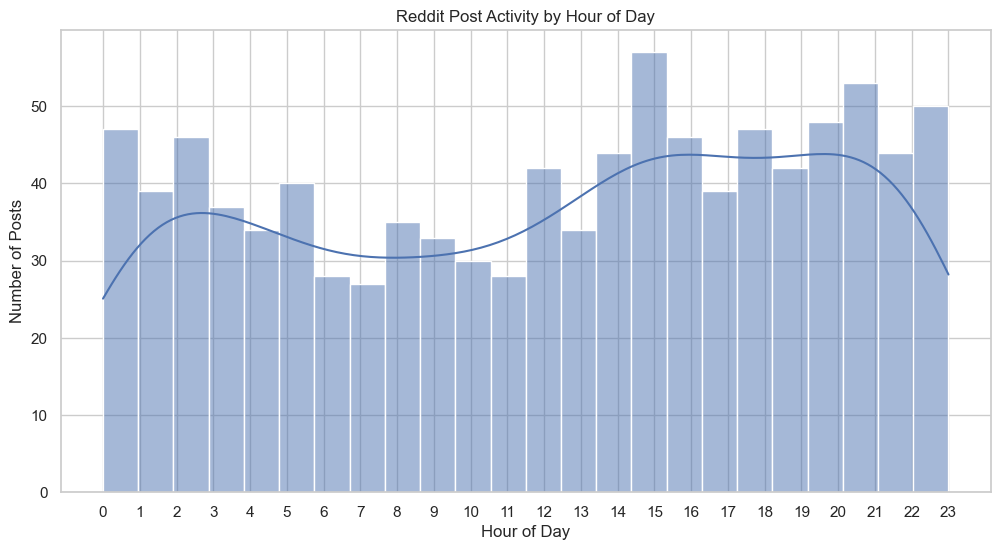

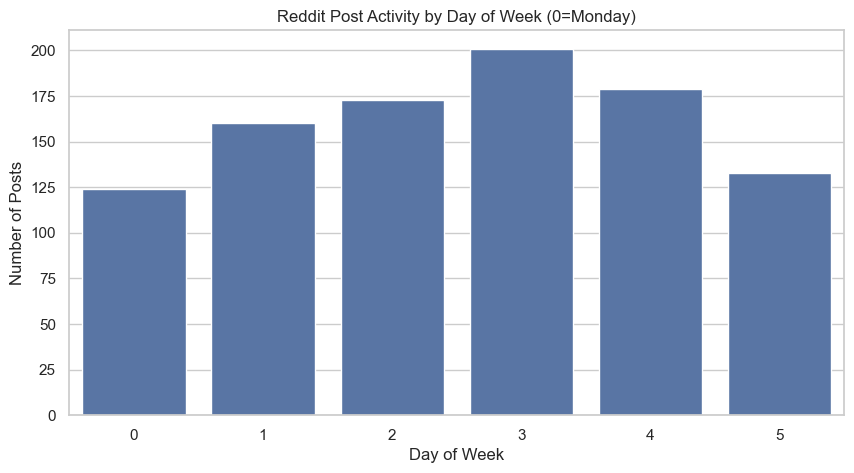

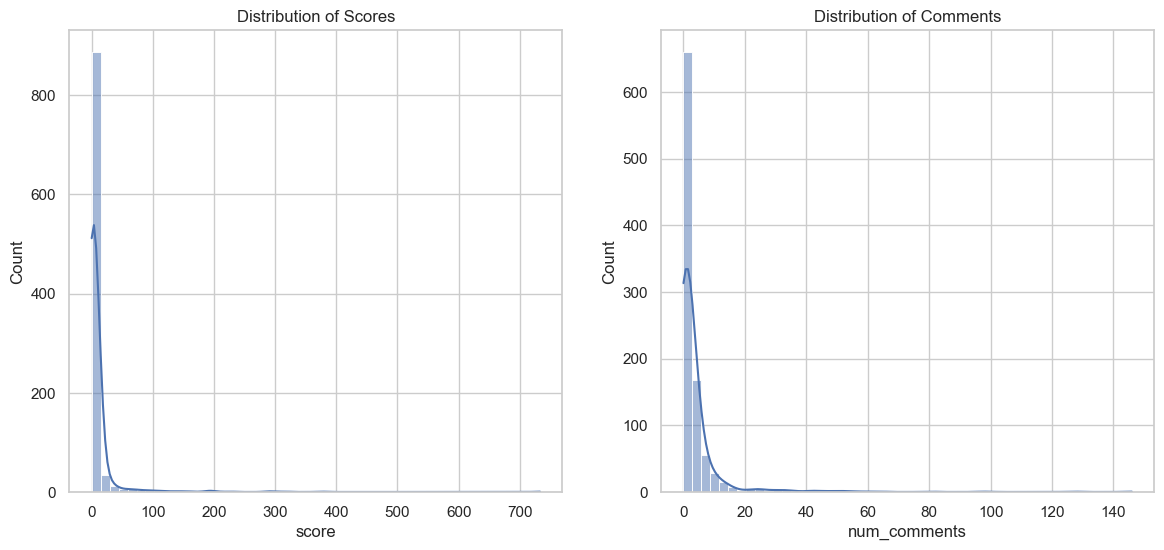

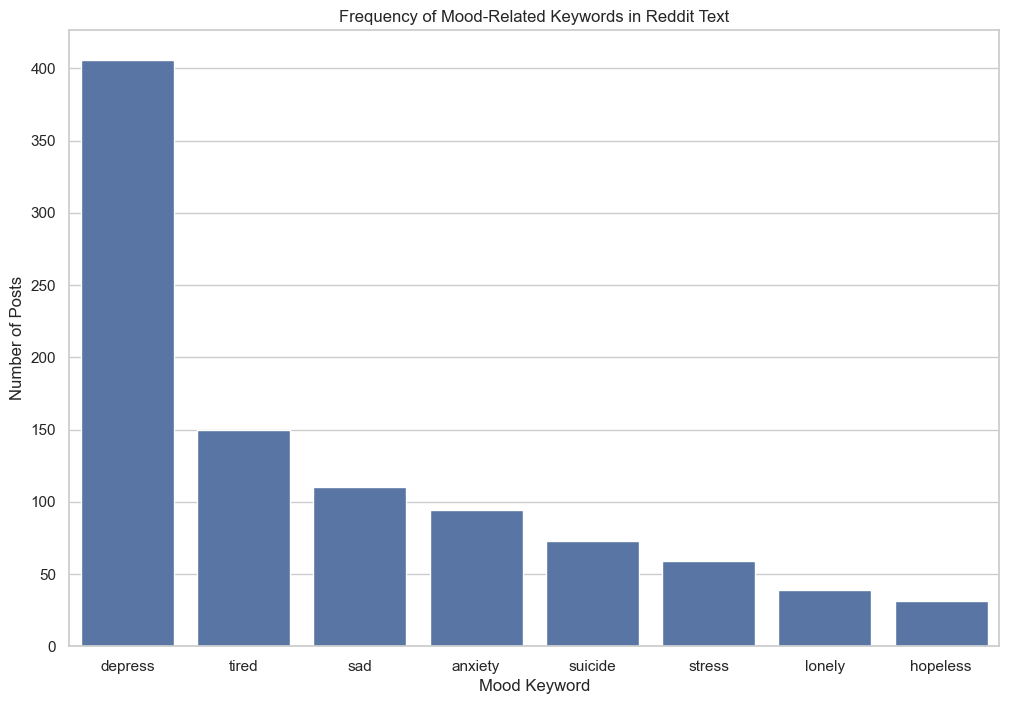

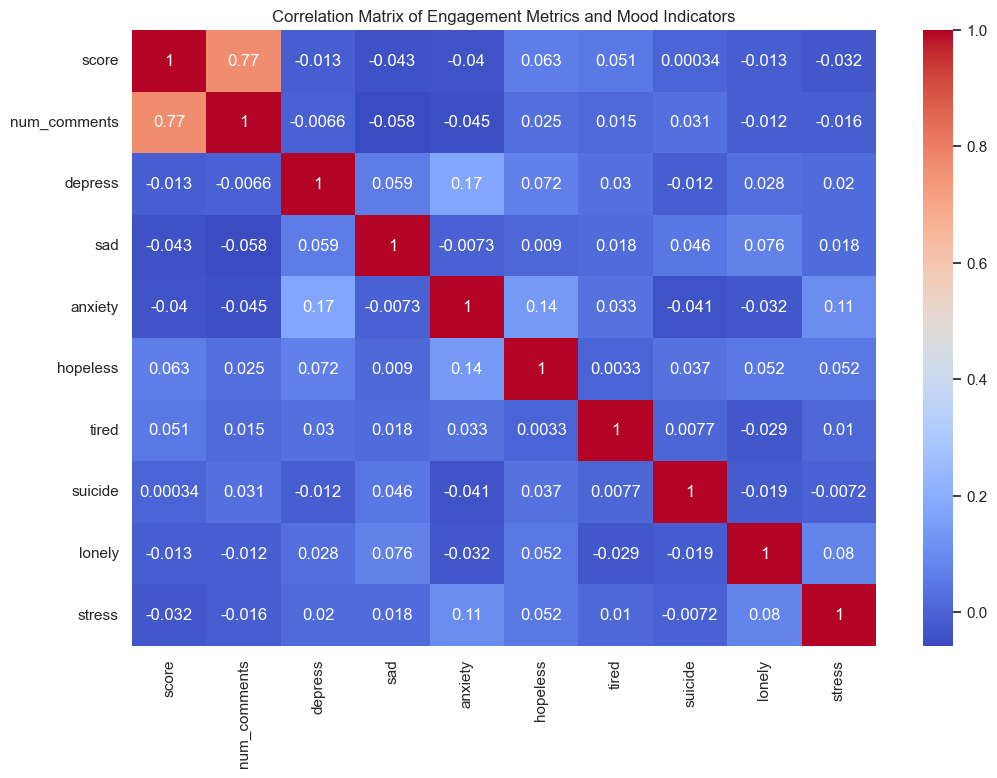

<Figure size 1200x800 with 0 Axes>

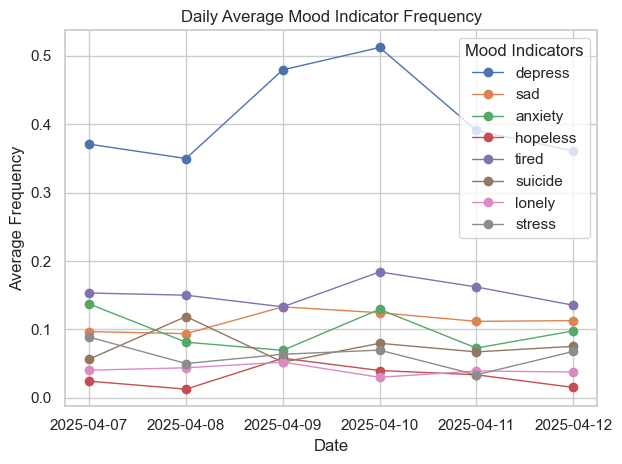

In [4]:
# %% [markdown]
# ## 1. Data Loading and Initial Inspection

# %%
# Load datasets
reddit_df = pd.read_csv("./reddit_recent_1000.csv")

# Inspect first rows
reddit_df.head()

# %% [markdown]
# ## 2. Data Preprocessing

# %%
# Convert timestamps to datetime (already formatted string)
reddit_df['created_utc'] = pd.to_datetime(reddit_df['created_utc'])

# Create a combined text field and time-based features
reddit_df['text'] = reddit_df['title'].fillna('') + ' ' + reddit_df['selftext'].fillna('')
reddit_df['year'] = reddit_df['created_utc'].dt.year
reddit_df['month'] = reddit_df['created_utc'].dt.month
reddit_df['day_of_week'] = reddit_df['created_utc'].dt.dayofweek
reddit_df['hour'] = reddit_df['created_utc'].dt.hour
reddit_df['date'] = reddit_df['created_utc'].dt.date

# Check for missing values
reddit_df.isnull().sum()

# %% [markdown]
# ## 3. Exploratory Data Analysis (EDA)

# ### a. Activity Patterns by Time

# %%
plt.figure(figsize=(12,6))
sns.histplot(reddit_df['hour'], bins=24, kde=True)
plt.title("Reddit Post Activity by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Posts")
plt.xticks(range(0,24))
plt.show()

# %%
plt.figure(figsize=(10,5))
sns.countplot(x='day_of_week', data=reddit_df)
plt.title("Reddit Post Activity by Day of Week (0=Monday)")
plt.xlabel("Day of Week")
plt.ylabel("Number of Posts")
plt.show()

# ### b. Popularity and Engagement Metrics

# %%
# Summary statistics of engagement metrics
engagement_metrics = ['score', 'num_comments']
reddit_df[engagement_metrics].describe()

# %%
# Distribution of engagement metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(reddit_df['score'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Scores')

sns.histplot(reddit_df['num_comments'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Comments')

plt.show()

# ### c. Mood Indicators Analysis

# %%
# Define key mood indicators
mood_keywords = ['depress', 'sad', 'anxiety', 'hopeless', 'tired', 'suicide', 'lonely', 'stress']

# Create new columns for mood indicators
for word in mood_keywords:
    reddit_df[word] = reddit_df['text'].str.contains(word, case=False).astype(int)

# Mood indicator summary
mood_summary = reddit_df[mood_keywords].sum().sort_values(ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x=mood_summary.index, y=mood_summary.values)
plt.title('Frequency of Mood-Related Keywords in Reddit Text')
plt.xlabel('Mood Keyword')
plt.ylabel('Number of Posts')
plt.show()

# %% [markdown]
# ## 4. Correlation Analysis

# %%
# Correlation matrix
corr_matrix = reddit_df[['score', 'num_comments'] + mood_keywords].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Engagement Metrics and Mood Indicators")
plt.show()

# %% [markdown]
# ## 5. Temporal Analysis of Mood Indicators

# %%
# Mood indicators over time (by date)
daily_mood = reddit_df.groupby('date')[mood_keywords].mean()

plt.figure(figsize=(12,8))
daily_mood.plot(marker='o', linewidth=1)
plt.title('Daily Average Mood Indicator Frequency')
plt.xlabel('Date')
plt.ylabel('Average Frequency')
plt.legend(title='Mood Indicators')
plt.grid(True)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 6. Insights and Conclusions

# %%
# Key insights:
# - Peak Reddit activity times
# - Most common mood-related keywords
# - Relationship between engagement (score, comments) and depression indicators
# - Temporal trend of mood indicators

# (Interpret these findings based on visualizations above.)

# ---
# End of analysis.


# Key insights:
# - Peak Reddit activity times
# - Most common mood-related keywords
# - Relationship between engagement (score, comments) and depression indicators
# - Temporal trend of mood indicators
